In [1]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.utils import Sequence, plot_model

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
files = glob.glob("/kaggle/input/synthetic-turkish-license-plates/license-plates/*.png")
all_files = [(os.path.splitext(os.path.basename(file))[0], file) for file in files]

X = [filename[1] for filename in all_files]
y1 = np.array([plate_label[0].replace("-", "")[0] for plate_label in all_files])
y2 = np.array([plate_label[0].replace("-", "")[1] for plate_label in all_files])
y3 = np.array([plate_label[0].replace("-", "")[2] for plate_label in all_files])
y4 = np.array([plate_label[0].replace("-", "")[3] for plate_label in all_files])
y5 = np.array([plate_label[0].replace("-", "")[4] for plate_label in all_files])
y6 = np.array([plate_label[0].replace("-", "")[5] for plate_label in all_files])
y7 = np.array([plate_label[0].replace("-", "")[6] for plate_label in all_files])

In [3]:
X, y1, y2, y3, y4, y5, y6, y7 = shuffle(X, y1, y2, y3, y4, y5, y6, y7)
categories = np.array(list("ABCDEFGHIJKLMNOPRSTUVYZ0123456789"))
onehot_enc = OneHotEncoder(sparse=False)
onehot_enc.fit(categories.reshape(-1, 1))

y1 = onehot_enc.transform(y1.reshape(-1, 1))
y2 = onehot_enc.transform(y2.reshape(-1, 1))
y3 = onehot_enc.transform(y3.reshape(-1, 1))
y4 = onehot_enc.transform(y4.reshape(-1, 1))
y5 = onehot_enc.transform(y5.reshape(-1, 1))
y6 = onehot_enc.transform(y6.reshape(-1, 1))
y7 = onehot_enc.transform(y7.reshape(-1, 1))

X_train, X_test, \
y1_train, y1_test, \
y2_train, y2_test, \
y3_train, y3_test, \
y4_train, y4_test, \
y5_train, y5_test, \
y6_train, y6_test, \
y7_train, y7_test = \
    train_test_split(X, y1, y2, y3, y4, y5, y6, y7, test_size=0.2, random_state=42)

In [4]:
class MyCustomGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y1 = self.labels[0][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y2 = self.labels[1][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y3 = self.labels[2][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y4 = self.labels[3][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y5 = self.labels[4][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y6 = self.labels[5][idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y7 = self.labels[6][idx * self.batch_size : (idx+1) * self.batch_size]
        
        return np.array([cv2.imread(filename) / 255.0
                         for filename in batch_x]), \
            [np.array(batch_y1), np.array(batch_y2), np.array(batch_y3), np.array(batch_y4), np.array(batch_y5), np.array(batch_y6), np.array(batch_y7)]

In [5]:
batch_size = 32

training_batch_generator = MyCustomGenerator(X_train, (y1_train, y2_train, y3_train, y4_train, y5_train, y6_train, y7_train), batch_size)
test_batch_generator = MyCustomGenerator(X_test, (y1_test, y2_test, y3_test, y4_test, y5_test, y6_test, y7_test), batch_size)

In [6]:
WIDTH = 1025
HEIGHT = 218
CHANNEL = 3

inputs = Input(shape=(HEIGHT, WIDTH, CHANNEL))
conv1 = Conv2D(8, kernel_size=3, activation="relu")(inputs)
conv1 = Conv2D(8, kernel_size=3, activation="relu")(conv1)
conv1 = MaxPooling2D()(conv1)

conv2 = Conv2D(16, kernel_size=3, activation="relu")(conv1)
conv2 = Conv2D(16, kernel_size=3, activation="relu")(conv2)
conv2 = MaxPooling2D()(conv2)

conv3 = Conv2D(16, kernel_size=3, activation="relu")(conv2)
conv3 = Conv2D(16, kernel_size=3, activation="relu")(conv3)
conv3 = MaxPooling2D()(conv3)

dense = Flatten()(conv3)

dense = Dense(64, activation="relu")(dense)

dense_output1 = Dense(33, activation="softmax")(dense)
dense_output2 = Dense(33, activation="softmax")(dense)
dense_output3 = Dense(33, activation="softmax")(dense)
dense_output4 = Dense(33, activation="softmax")(dense)
dense_output5 = Dense(33, activation="softmax")(dense)
dense_output6 = Dense(33, activation="softmax")(dense)
dense_output7 = Dense(33, activation="softmax")(dense)

model = Model(inputs=inputs, \
              outputs=[dense_output1, dense_output2, dense_output3, dense_output4, dense_output5, dense_output6, dense_output7])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 1025, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 1023, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 214, 1021, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 107, 510, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [7]:
plot_model(model)

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
history = model.fit_generator(training_batch_generator, epochs=10)

Epoch 1/10
2500/2500 [==============================] - 1420s 568ms/step - loss: 7.2666 - dense_2_loss: 0.4788 - dense_3_loss: 0.5542 - dense_4_loss: 1.1017 - dense_5_loss: 1.7283 - dense_6_loss: 1.6196 - dense_7_loss: 0.9883 - dense_8_loss: 0.7957 - dense_2_acc: 0.8374 - dense_3_acc: 0.8175 - dense_4_acc: 0.6515 - dense_5_acc: 0.4714 - dense_6_acc: 0.5225 - dense_7_acc: 0.6688 - dense_8_acc: 0.7287
Epoch 2/10
 965/2500 [==========>...................] - ETA: 12:56 - loss: 2.7108 - dense_2_loss: 0.1053 - dense_3_loss: 0.1457 - dense_4_loss: 0.3315 - dense_5_loss: 0.7293 - dense_6_loss: 0.8223 - dense_7_loss: 0.3935 - dense_8_loss: 0.1833 - dense_2_acc: 0.9659 - dense_3_acc: 0.9502 - dense_4_acc: 0.8876 - dense_5_acc: 0.7547 - dense_6_acc: 0.7371 - dense_7_acc: 0.8753 - dense_8_acc: 0.9449

In [10]:
predictions = model.predict_generator(test_batch_generator)

In [11]:
y1_hat = onehot_enc.inverse_transform(predictions[0])
y2_hat = onehot_enc.inverse_transform(predictions[1])
y3_hat = onehot_enc.inverse_transform(predictions[2])
y4_hat = onehot_enc.inverse_transform(predictions[3])
y5_hat = onehot_enc.inverse_transform(predictions[4])
y6_hat = onehot_enc.inverse_transform(predictions[5])
y7_hat = onehot_enc.inverse_transform(predictions[6])

In [12]:
y1_test = onehot_enc.inverse_transform(y1_test)
y2_test = onehot_enc.inverse_transform(y2_test)
y3_test = onehot_enc.inverse_transform(y3_test)
y4_test = onehot_enc.inverse_transform(y4_test)
y5_test = onehot_enc.inverse_transform(y5_test)
y6_test = onehot_enc.inverse_transform(y6_test)
y7_test = onehot_enc.inverse_transform(y7_test)

In [13]:
print(classification_report(y1_test, y1_hat))
print("#" * 40)
print(classification_report(y2_test, y2_hat))
print("#" * 40)
print(classification_report(y3_test, y3_hat))
print("#" * 40)
print(classification_report(y4_test, y4_hat))
print("#" * 40)
print(classification_report(y5_test, y5_hat))
print("#" * 40)
print(classification_report(y6_test, y6_hat))
print("#" * 40)
print(classification_report(y7_test, y7_hat))
print("#" * 40)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2330
           1       1.00      1.00      1.00      2545
           2       0.99      1.00      1.00      2567
           3       1.00      1.00      1.00      2400
           4       1.00      1.00      1.00      2488
           5       1.00      1.00      1.00      2434
           6       1.00      1.00      1.00      2462
           7       1.00      1.00      1.00      2539
           8       1.00      0.91      0.95       235

    accuracy                           1.00     20000
   macro avg       1.00      0.99      0.99     20000
weighted avg       1.00      1.00      1.00     20000

########################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1999
           1       1.00      1.00      1.00      2021
           2       1.00      1.00      1.00      2031
           3       1.00      1.00    

(218, 1025, 3)


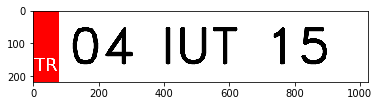

In [14]:
test_image = next(iter(test_batch_generator))
print(test_image[0][1].shape)
plt.imshow(test_image[0][1])
plt.show()

In [15]:
prediction = model.predict(test_image[0][1].reshape(1, 218, 1025, 3))

In [16]:
for ch in prediction:
    print(onehot_enc.inverse_transform(ch)[0][0], end="")

04IUT15